<a href="https://colab.research.google.com/github/Rickkk2/test/blob/main/Technical_exercise_Data_scientist_intern_Giskard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Original model**

In [1]:
# Install the Giskard library
#!pip install giskard

In [2]:
# Connect to the external ML worker in daemon mode
#!giskard worker start -d


In [43]:
# Required dependencies
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from ctgan import CTGAN
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.single_table import CopulaGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import get_column_plot
from sdv.sampling import Condition

In [4]:
# Read dataset and open as dataframe
url = 'https://raw.githubusercontent.com/Giskard-AI/giskard-client/main/sample_data/classification/credit/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python")
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   sex                         1000 non-null   object
 10  personal_status             1000 non-null   object
 11  other_debtors               1000 non-null   object
 12  present_res_since           1000 non-null   int64 
 13  property                    1000 non-null   objec

In [5]:
# See the domain and distribution of each column
for column in credit:
  print("------------------------------\n", credit[column].value_counts(), sep ='')

------------------------------
0    700
1    300
Name: default, dtype: int64
------------------------------
no checking account                                   394
< 0 DM                                                274
0 <= ... < 200 DM                                     269
>= 200 DM / salary assignments for at least 1 year     63
Name: account_check_status, dtype: int64
------------------------------
24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
60     13
27     13
42     11
11      9
20      8
8       7
4       6
45      5
7       5
39      5
14      4
13      4
33      3
28      3
54      2
16      2
22      2
47      1
5       1
26      1
72      1
40      1
Name: duration_in_month, dtype: int64
------------------------------
existing credits paid back duly till now                       530
critical account/ other credits existing (not at this bank)    293
delay in paying off in the past                        

In [6]:
# Declare the type of each column in the dataset(example: category, numeric, text)
column_types = {'default':"category",
               'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_emp_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_res_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

In [7]:
# feature_types is used to declare the features the model is trained on
feature_types = {i:column_types[i] for i in column_types if i!='default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys() if feature_types[key]=="numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [key for key in feature_types.keys() if feature_types[key]=="category"]
categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False)) ])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
      ('cat', categorical_transformer, columns_to_encode)
          ]
)

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter =1000))])

# Split the data into train and test
Y = credit['default']
X = credit.drop(columns="default")
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.20,random_state = 30, stratify = Y)

In [8]:
# Train the Logistic Regression model and get the mean accuracy on the given test data and labels
clf_logistic_regression.fit(X_train, Y_train)
clf_logistic_regression.score(X_test, Y_test)

0.785

0.785 is a good result for accuracy. However, let's try to improve it by applying data augmentation techniques on the training set.

In [9]:
# Our real dataset
train_data = pd.concat([Y_train, X_train], axis=1, join='inner')

# **Data Augmentation**

In [ ]:
# We will use the Synthetic Data Vault (SDV) library to create tabular synthetic data
!pip install sdv

## GaussianCopulaSynthesizer

In [11]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train_data)

In [12]:
synthesizer1 = GaussianCopulaSynthesizer(metadata)
synthesizer1.fit(train_data)

In [13]:
synthesizer1.reset_sampling()
synthetic_data1 = synthesizer1.sample(num_rows=250)
for column in synthetic_data1:
  print("------------------------------\n", synthetic_data1[column].value_counts(), sep ='')

------------------------------
0    165
1     85
Name: default, dtype: int64
------------------------------
0 <= ... < 200 DM                                     84
< 0 DM                                                71
no checking account                                   70
>= 200 DM / salary assignments for at least 1 year    25
Name: account_check_status, dtype: int64
------------------------------
7     13
17    13
11    11
26    11
23    11
16    10
8     10
24     9
18     9
10     9
25     8
15     8
6      7
31     7
9      6
36     6
20     6
30     5
37     5
33     5
21     5
19     5
27     5
13     4
29     4
38     4
14     4
12     4
35     4
42     4
32     4
22     4
40     3
5      3
39     3
41     3
28     3
49     2
60     2
56     2
48     2
44     2
46     2
45     1
34     1
58     1
Name: duration_in_month, dtype: int64
------------------------------
existing credits paid back duly till now                       98
critical account/ other credits existing (n

In [14]:
Y_train_aug1 = synthetic_data1['default']
X_train_aug1 = synthetic_data1.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug1]), pd.concat([Y_train, Y_train_aug1]))
clf_logistic_regression.score(X_test, Y_test)

0.76

0.76 is still a good result for accuracy, but worse than that obtained without data augmentation



In [15]:
quality_report1 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data1,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]



Overall Quality Score: 78.55%

Properties:
Column Shapes: 82.82%
Column Pair Trends: 74.28%


In [16]:
diagnostic_report1 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data1,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:15<00:00,  3.79s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [17]:
fig1 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data1,
    column_name='credit_history',
    metadata=metadata
)
    
fig1.show()

## CTGANSynthesizer

In [18]:
synthesizer2 = CTGANSynthesizer(metadata)
synthesizer2.fit(train_data)

In [19]:
synthesizer2.reset_sampling()
synthetic_data2 = synthesizer2.sample(num_rows=250)
for column in synthetic_data2:
  print("------------------------------\n", synthetic_data2[column].value_counts(), sep ='')

------------------------------
0    184
1     66
Name: default, dtype: int64
------------------------------
no checking account                                   114
0 <= ... < 200 DM                                      66
< 0 DM                                                 55
>= 200 DM / salary assignments for at least 1 year     15
Name: account_check_status, dtype: int64
------------------------------
4     31
22    25
20    18
21    18
23    17
24    16
14    10
6      9
13     9
15     8
17     7
12     7
7      6
18     6
8      6
5      5
11     5
10     5
9      5
16     4
26     3
19     3
27     3
25     3
36     2
33     2
51     2
32     2
30     2
60     2
35     2
28     1
29     1
53     1
45     1
34     1
55     1
31     1
Name: duration_in_month, dtype: int64
------------------------------
existing credits paid back duly till now                       145
critical account/ other credits existing (not at this bank)     63
delay in paying off in the past            

In [20]:
Y_train_aug2 = synthetic_data2['default']
X_train_aug2 = synthetic_data2.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug2]), pd.concat([Y_train, Y_train_aug2]))
clf_logistic_regression.score(X_test, Y_test)

0.79

0.79 improves on original accuracy

In [21]:
quality_report2 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data2,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]



Overall Quality Score: 86.51%

Properties:
Column Shapes: 89.28%
Column Pair Trends: 83.74%


In [22]:
diagnostic_report2 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data2,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [23]:
fig2 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data2,
    column_name='credit_history',
    metadata=metadata
)

fig2.show()

## TVAESynthesizer


In [24]:
synthesizer3 = TVAESynthesizer(metadata)
synthesizer3.fit(train_data)

In [25]:
synthesizer3.reset_sampling()
synthetic_data3 = synthesizer3.sample(num_rows=250)
for column in synthetic_data3:
  print("------------------------------\n", synthetic_data3[column].value_counts(), sep ='')

------------------------------
0    193
1     57
Name: default, dtype: int64
------------------------------
no checking account    140
0 <= ... < 200 DM       61
< 0 DM                  49
Name: account_check_status, dtype: int64
------------------------------
10    28
9     28
11    26
13    20
8     15
7     14
12    14
14    10
6      9
15     6
25     6
4      6
16     5
46     4
50     4
24     4
48     4
45     4
5      3
39     3
42     3
41     3
40     3
17     2
20     2
22     2
38     2
44     2
23     2
37     2
18     2
54     1
53     1
32     1
51     1
36     1
47     1
60     1
29     1
26     1
57     1
34     1
52     1
Name: duration_in_month, dtype: int64
------------------------------
existing credits paid back duly till now                       210
critical account/ other credits existing (not at this bank)     40
Name: credit_history, dtype: int64
------------------------------
domestic appliances    104
car (new)              102
radio/television        25
ca

In [26]:
Y_train_aug3 = synthetic_data3['default']
X_train_aug3 = synthetic_data3.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug3]), pd.concat([Y_train, Y_train_aug3]))
clf_logistic_regression.score(X_test, Y_test)

0.76

0.765 doesn't improve

In [27]:
quality_report3 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data3,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]



Overall Quality Score: 73.55%

Properties:
Column Shapes: 79.34%
Column Pair Trends: 67.77%


In [28]:
diagnostic_report3 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data3,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the categories present in the real data


In [29]:
fig3 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data3,
    column_name='credit_history',
    metadata=metadata
)

fig3.show()

## CopulaGANSynthesizer

In [30]:
synthesizer4 = CopulaGANSynthesizer(metadata)
synthesizer4.fit(train_data)

In [31]:
synthesizer4.reset_sampling()
synthetic_data4 = synthesizer4.sample(num_rows=250)
for column in synthetic_data4:
  print("------------------------------\n", synthetic_data4[column].value_counts(), sep ='')

------------------------------
0    220
1     30
Name: default, dtype: int64
------------------------------
no checking account                                   100
0 <= ... < 200 DM                                      73
< 0 DM                                                 59
>= 200 DM / salary assignments for at least 1 year     18
Name: account_check_status, dtype: int64
------------------------------
23    16
9     15
8     15
13    13
15    12
18    11
5     11
21    11
20    11
11    10
10     9
17     8
14     8
22     8
19     8
27     8
7      7
16     7
12     6
36     6
28     5
37     5
24     5
35     4
25     3
6      3
45     3
52     3
40     2
33     2
29     2
32     2
26     2
42     1
43     1
38     1
44     1
55     1
39     1
41     1
48     1
60     1
Name: duration_in_month, dtype: int64
------------------------------
existing credits paid back duly till now                       116
critical account/ other credits existing (not at this bank)     83
delay i

In [32]:
Y_train_aug4 = synthetic_data4['default']
X_train_aug4 = synthetic_data4.drop(columns="default")

clf_logistic_regression.fit(pd.concat([X_train, X_train_aug4]), pd.concat([Y_train, Y_train_aug4]))
clf_logistic_regression.score(X_test, Y_test)

0.825

0.755 doesn't improve

In [33]:
quality_report4 = evaluate_quality(
    real_data=train_data,
    synthetic_data=synthetic_data4,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]



Overall Quality Score: 84.23%

Properties:
Column Shapes: 87.19%
Column Pair Trends: 81.27%


In [34]:
diagnostic_report4 = run_diagnostic(
    real_data=train_data,
    synthetic_data=synthetic_data4,
    metadata=metadata)

Creating report: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


DiagnosticResults:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data covers over 90% of the categories present in the real data
✓ Over 90% of the synthetic rows are not copies of the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data


In [35]:
fig4 = get_column_plot(
    real_data=train_data,
    synthetic_data=synthetic_data4,
    column_name='credit_history',
    metadata=metadata
)

fig4.show()

# **Improvement and Conclusions**

Apparently, CTGANSynthesizer is the best model for this scenario. When doing data augmentation on a tabular dataset, a balance must be achieved in adding rows to avoid underfitting and overfitting. 

In [37]:
def res(x):
  synthesizer2.reset_sampling()
  synthetic_data = synthesizer2.sample(num_rows=x)

  Y_train_aug = synthetic_data['default']
  X_train_aug = synthetic_data.drop(columns="default")

  clf_logistic_regression.fit(pd.concat([X_train, X_train_aug]), pd.concat([Y_train, Y_train_aug]))
  return clf_logistic_regression.score(X_test, Y_test)

In [52]:
x = list(range(1,5000))
y = []

for id, i in enumerate(x):
  y.append(res(x[id]))

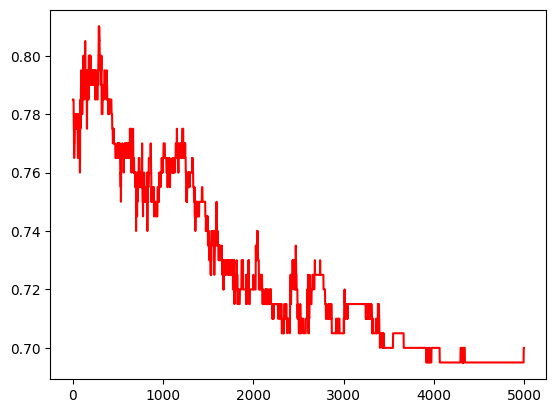

In [53]:
plt.plot(x, y, color='red')

plt.show()

In [64]:
maximum_val= y[0]
for i in range(1, len(y)): 
    if (y[i] > maximum_val):
        maximum_val = y[i]
print("Maximum Index position: ",y.index(maximum_val))

Maximum Index position:  285


In [65]:
x_max = list(range(250,750))
y_max = []

for id, i in enumerate(x_max):
  y_max.append(res(x[id]))

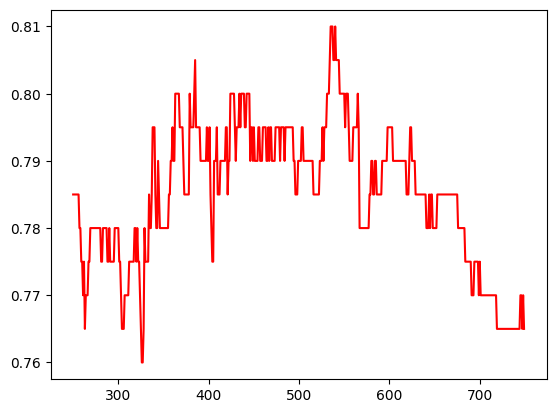

In [66]:
plt.plot(x_max, y_max, color='red')

plt.show()

We can observe several peaks that reach or exceed 0.8 and some that reach 0.81, which is an interesting improvement in accuracy.

As we have calculated above, the first time the maximum value is reached is with 286 new rows.

In [69]:
res(286)

0.81

We have managed to improve from 0.785 to 0.81 using the GAN-based synthesizer. Perhaps a method or combination of methods can be found to improve this result even further.